## Testing of field curvature
### Imaging setup:
- Lens: Olympus PLAPO 1x, zoom setting 2x
- Camera: H. Orca Flash 4
- Test sample: Ronchi grating (e.g. 40 lp/mm from Thorlabs) imaged at different focus position (stack).
- Illumination: even background using a smartphone screen (all white, 75% intensity)

MTF is accessed across field of view via local contrast metric.

Inspired by Roger Cicala's [blog post](https://www.lensrentals.com/blog/2018/06/developing-a-rapid-mtf-test-for-photo-and-video-lenses/).

This code is exploratory, not meant for streamlined processing.

- Author: Nikita Vladimirov 
- License: GPL-3.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tif
import glob, os
from pathlib import Path

### Explore TIFF stack of a Ronchi grid at different F-position

In [38]:
datafolder = "D:\\benchtopData\\Lens-testing"
datafiles = {"Olympus 1x": datafolder + "\\Olympus-MVPLAPO-1x\\MVP1x-zoom2-fstep10um\\stack-frange600-exp50intensity75pc.tif"}
f_step_um = 10

In [47]:
img = tif.imread(datafiles["Olympus 1x"])
im_z, im_h, im_w = img.shape
print(im_z, im_h, im_w)
print(f"Aspect ratio {im_w/im_h}")

61 2048 2048
Aspect ratio 1.0


In [48]:
# The number of ROIs to divide image along each axis
#these give integer number of rois along each axis, with aspect ratio close to the sensor ratio
#N_ROIs_H, N_ROIs_W = 32, 20 # Iris 15
N_ROIs_H, N_ROIs_W = 16, 16 # Orca Flash 4
roi_h, roi_w = int(im_h/N_ROIs_H), int(im_w/N_ROIs_W)
print(roi_h, roi_w)

128 128


5504 16844


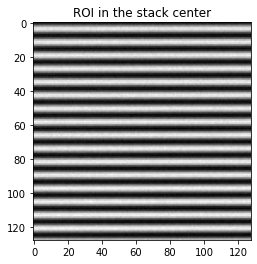

In [49]:
roi = img[im_z//2, roi_h*(N_ROIs_H//2 - 1): roi_h*(N_ROIs_H//2), 
               roi_w*(N_ROIs_W//2 - 1) : roi_w*(N_ROIs_W//2)]
plt.imshow(roi, cmap='gray')
plt.title("ROI in the stack center")
print(roi.min(), roi.max())
if roi.max() >= 65000:
    raise ValueError("Image is saturated!!!")

In [50]:
def contrast(roi):
    """Compute the contrast value, (max-min)/(max+min), from the image roi"""
    mini = np.percentile(roi, 1)
    maxi = np.percentile(roi, 99)
    contrast = (maxi - mini) / (maxi + mini)
    return contrast

In [51]:
contrast_table = np.empty((im_z, N_ROIs_H, N_ROIs_W))
for f in range(im_z):
    for j in range(N_ROIs_H):
        for i in range(N_ROIs_W):
            roi = img[f,j*roi_h:(j+1)*roi_h, i*roi_w:(i+1)*roi_w]
            contrast_table[f,j,i] = contrast(roi)

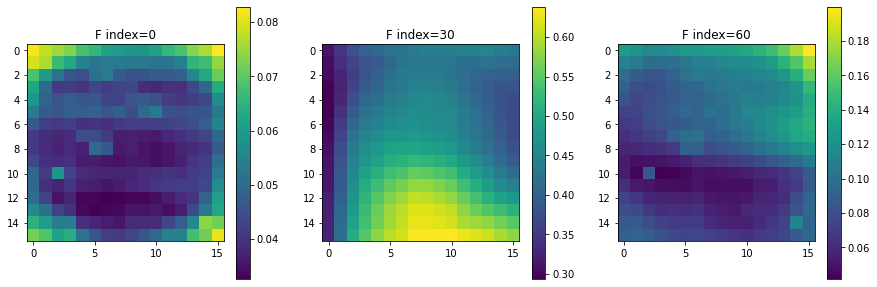

In [59]:
fig = plt.figure(figsize=(15, 5))
for ind, f in enumerate([0, im_z//2, im_z-1]):
    ax = plt.subplot(1, 3, ind+1)
    conmap = ax.imshow(contrast_table[f,:,:])
    ax.set_title("F index=" + str(f))
    plt.colorbar(conmap,ax=ax)

In [53]:
# Save contrast table as TIFF and explore interactively
tif.imsave(datafiles["Olympus 1x"][:-4] + "contrast.tiff", contrast_table)

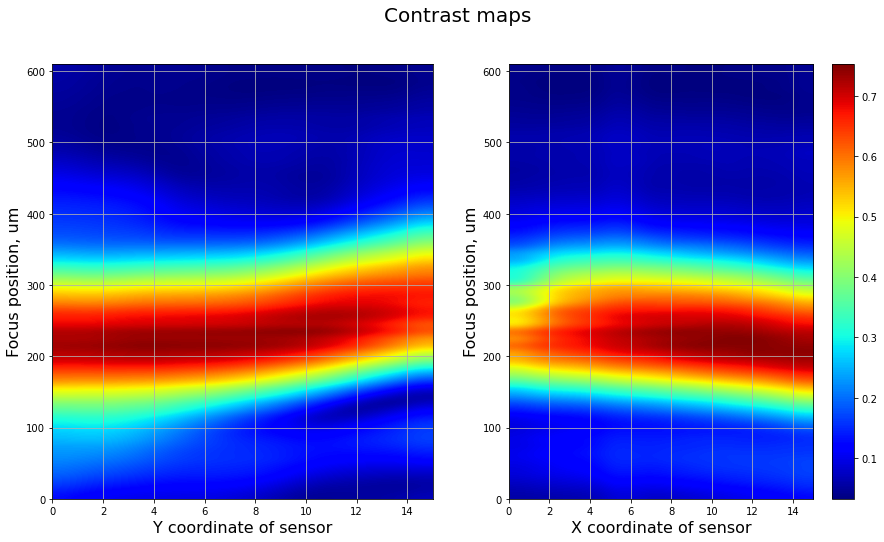

In [64]:
# slice the contrast map along XZ and YZ axis, therough the center
j = N_ROIs_W//2
contrast_yz = np.squeeze(contrast_table[:,:,j])
contrast_xz = np.squeeze(contrast_table[:,N_ROIs_H//2,:])

fig = plt.figure(figsize=(15, 8))
fig.suptitle('Contrast maps', fontsize=20)
ax0 = plt.subplot(1, 2, 1)
conmap0 = ax0.imshow(contrast_yz, extent=[0,N_ROIs_H-1, 0, f_step_um*im_z], aspect='auto', cmap='jet', interpolation='bicubic')
ax0.set_ylabel("Focus position, um", fontsize=16)
ax0.set_xlabel("Y coordinate of sensor", fontsize=16)
ax0.grid(True)

ax1 = plt.subplot(1, 2, 2)
conmap1 = ax1.imshow(contrast_xz, extent=[0,N_ROIs_W-1, 0, f_step_um*im_z], aspect='auto', cmap='jet', interpolation='bicubic')
ax1.set_ylabel("Focus position, um", fontsize=16)
ax1.set_xlabel("X coordinate of sensor", fontsize=16)
ax1.grid(True)
plt.colorbar(conmap1,ax=ax1)

In [55]:
# DOF calculation for the lens
# Based on [MicroscopyU](https://www.microscopyu.com/microscopy-basics/depth-of-field-and-depth-of-focus) formula.
# All units micron. Air objective.
n_det = 1 
cam_px_size = 6.5
lamb_em = 0.550
NA = 0.08
MAG = 2

DOF = n_det*lamb_em/NA**2 + n_det*cam_px_size/(MAG*NA)
print(f"Estimated DOF={int(DOF)} um, in air")

Estimated DOF=126 um, in air
